In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Dec 13, 2019
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import glob, os

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # controls which GPU to use

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook


model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss}) # newest Model
# model = load_model('./tmp/SharpMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss}) # SharpMask Model
# model = load_model('./tmp/VGG16FCN_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss}) # VGG16 FCN Model
# model = load_model('./tmp/VGG16DeepLab_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss}) # VGG16 Deeplab v2 Model

# cloudmodel = load_model('./tmp/RefineMask_Cloud.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
cloudmodel = load_model('./tmp/VGG16DeepLab_FijiCloudShadowMask256_4channel_allmosaics.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


./utils/loadcoraldata_utils.py:223: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}


<IPython.core.display.Javascript object>


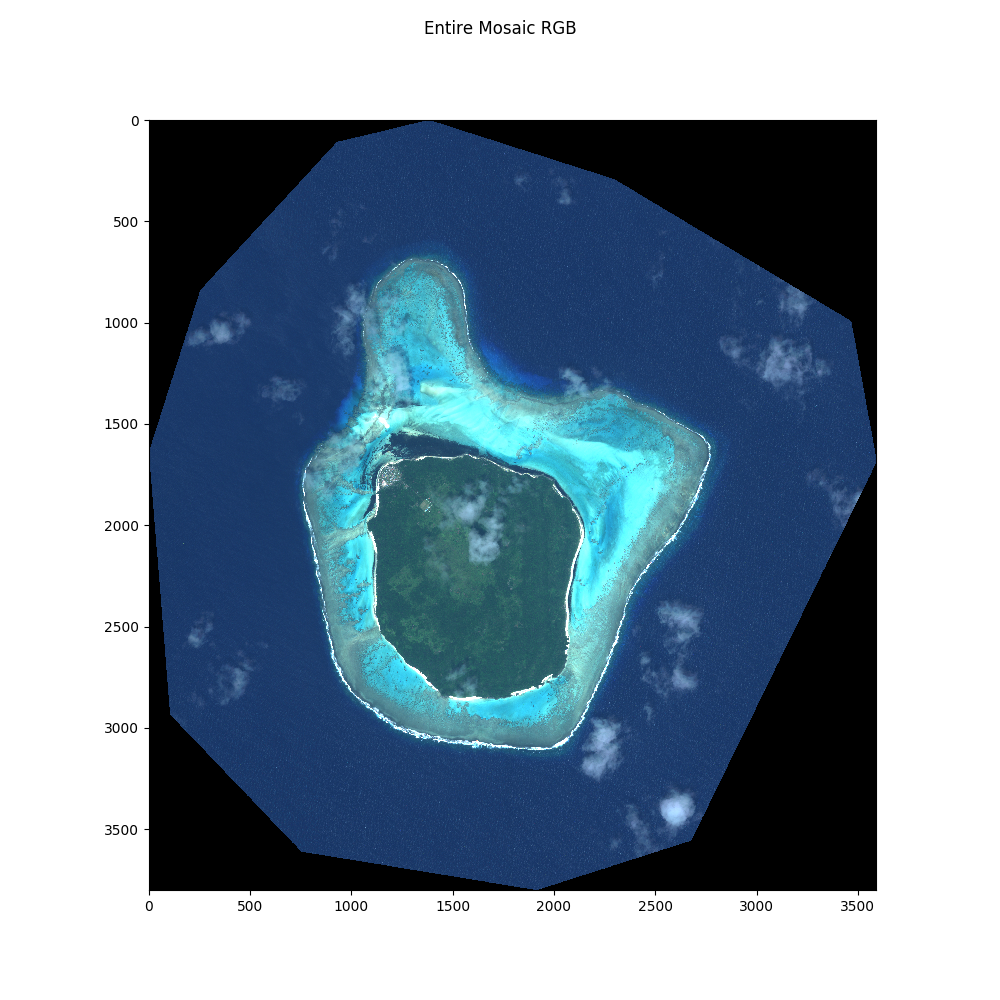

In [6]:
# Notes on Transects:
# Mosaic 1-3 Cicia
# Mosaic 4-7 Fulaga (4:80% east, 7: Spectrally poor)
# Mosaic 8-13 Kobara(8: 20% west, 9: 20% left, 12:70% east)
# Mosaic 14 Mago
# Mosaic 15-18 Matuka
# Mosaic 19-22 Moala (19: 10% Very Incomplete, 20: 70% east, 21: 30% west, 22: 20% South Spectrally poor)
# Mosaic 23-25 Nayau 
# Mosaic 26-32 Totoya (26: 80% west, 27: 70% west, 28: 20% east, 29: 60% east, 30: 30% east, 31: 80% west, 32: 80% west)
# Mosaic 33 Tuvuca
# Mosaic 34-38 Vanua Balavu # Way too big
# Mosaic 39-41 Vanua Vatu (40: 50% east, 41: 50% west)

### Specific mosaics to load

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_003.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_004.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_011.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-KOBARA-Fiji/Kobara_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-KOBARA-Fiji/Kobara_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_014.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-MAGO-Fiji/Mago_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-MAGO-Fiji/Mago_Habitats_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_015.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-MATUKA-Fiji/Matuka_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-MATUKA-Fiji/Matuka_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_020.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-MOALA-Fiji/Moala_Satellite_image_mosaic_KSLOF-002.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-MOALA-Fiji/Moala_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_023.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-NAYAU-Fiji/Nayau_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-NAYAU-Fiji/Nayau_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_031.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-TOTOYA-Fiji/Totoya_Satellite_image_mosaic_KSLOF-002.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-TOTOYA-Fiji/Totoya_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_033.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-TUVUCA-Fiji/Tuvuca_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-TUVUCA-Fiji/FJTV_20150731_Habitat_classes_raster.tif'

imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_039.TIF'
imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-VANUAVATU-FIJI/VanuaVatu_Satellite_image_mosaic_KSLOF.tif'
truthpath = '/home/shared/NeMO-Net Data/KSLOF-VANUAVATU-FIJI/VanuaVatu_Habitat_classes_raster_KSLOF.tif'

# Load classes from json file, then downscale to 9 classes
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
FijiTruth_24classes = np.copy(Fiji.truthimage_consolidated)
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
FijiTruth_Ved = np.copy(Fiji.truthimage_consolidated)

Fiji_original = coralutils.CoralData(imgpath_original, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji_original.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji_original.Consolidate_classes(newclassdict=json_data["MajorConsolidated_ClassDict"], transferdict=json_data["L32MajorConsolidated_Dict"])
FijiTruth_Major = np.copy(Fiji_original.truthimage_consolidated)

labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev_Ved = dict((v,k) for k,v in labelkey.items()) #flip k,v
labelkey_24classes = json_data["L3_ClassDict"]
class_indices_rev_24classes = dict((v,k) for k,v in labelkey_24classes.items()) #flip k,v
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev) # Print downsampled generic classes

# Loads directories to look into for training/validation (Not used if not training data)
with open("init_args - Jarrett.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)
train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

# Assume here that channels are RGB + NIR
num_channels = 4
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 100*np.ones(num_channels)
pixel_std = 100*np.ones(num_channels) # Pixel mean and standard deviation

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3) 

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Fiji_RGB) # Show RGB value of entire loaded mosaic, capped at 255
plt.suptitle('Entire Mosaic RGB')

# associated colormap for prediction (used later)
cmap_24classes = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:pink', '#d83f3f', '#f140a0', '#ec684e', '#ff8181',
                             '#161616', 'xkcd:dark blue', '#f8f8f8', 'xkcd:grey', '#2ca4ab',
                             'xkcd:forest', '#189d60', '#916d9e', 'xkcd:tan',
                             '#d35583', 'xkcd:olive', 'xkcd:blue', 'xkcd:orange'])
bounds_24classes = [i+0.5 for i in range(25)]
norm_24classes = colors.BoundaryNorm([b+0.5 for b in bounds_24classes], cmap_24classes.N)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

<IPython.core.display.Javascript object>


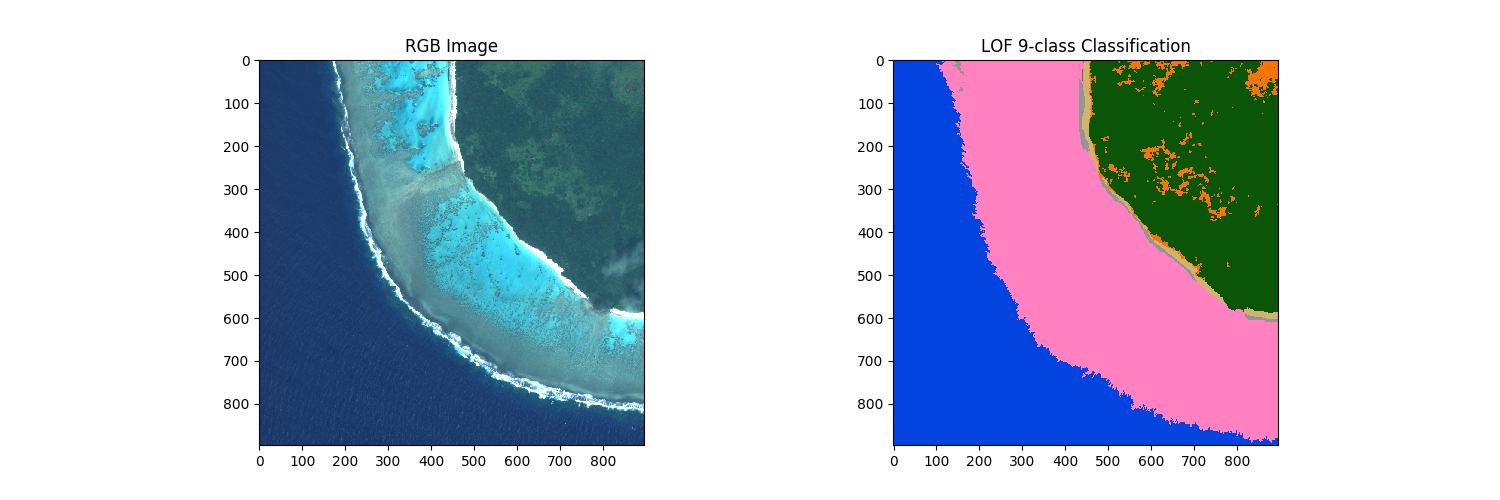

<IPython.core.display.Javascript object>


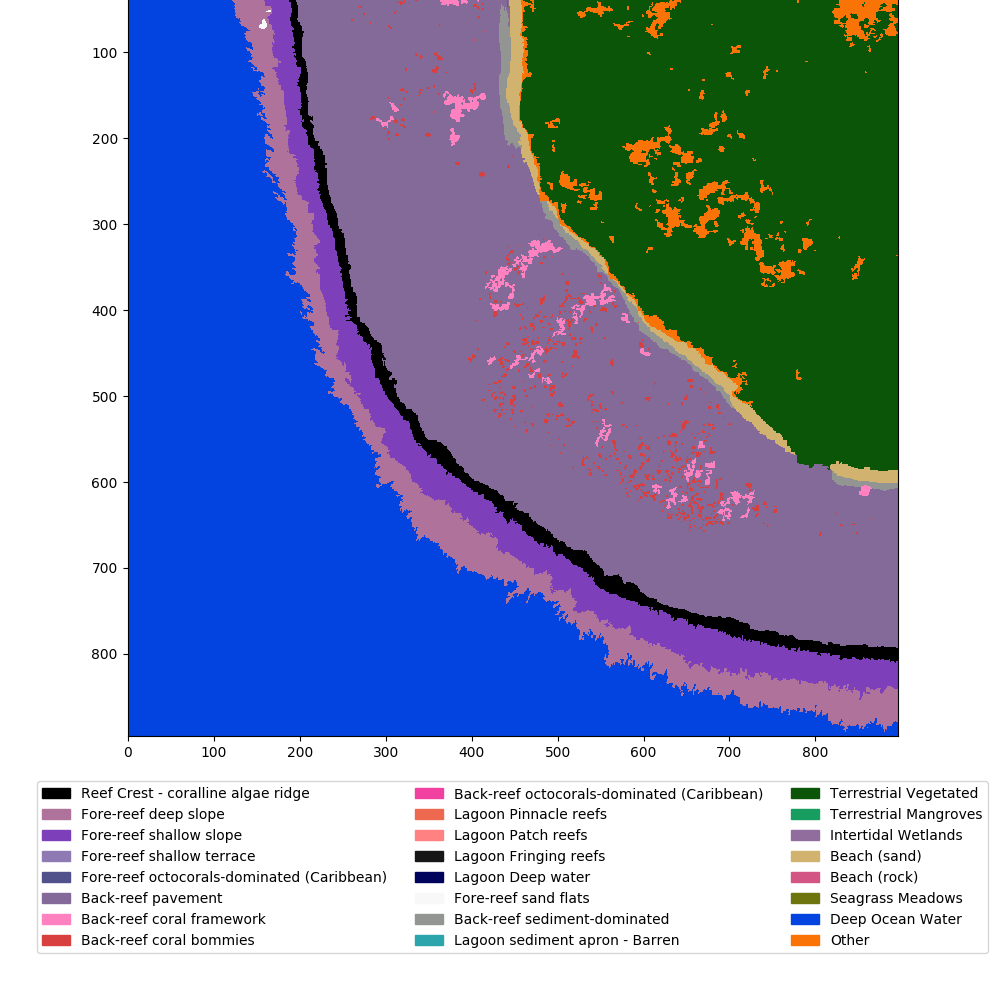

In [8]:
# Specify where to predict

# X,Y coordinates of location to predict
ystart = 2200
xstart = 600
ygeo = ystart*Fiji.geotransform[5]+Fiji.geotransform[3]
xgeo = xstart*Fiji.geotransform[1]+Fiji.geotransform[0]
# Xlength, Ylength, starting from X Y coordinates
xlen = 1024
ylen = 1024
# Size of prediction (center only, meaning if you specify 128, each patch will only predict the center 128x128 from the 256x256)
predict_size = 128
patch_size = 256 # regular patch size

# Loads the specified ylen x xlen patch into testimage, along with crop_len, offstart
Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
Fiji.testimage = np.delete(Fiji.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR
crop_len = int(np.floor(patch_size/2))
offstart = crop_len-int(np.floor(predict_size/2)) # calculates amount of pixels to shave off from each side, since we are only predicting on center (if predict_size = 256, offstart=0)
Testtruth = FijiTruth_Ved[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_24classes = FijiTruth_24classes[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_Major = FijiTruth_Major[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]

fig = plt.figure(2,figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('RGB Image')
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])
patch_R = 255/300*Fiji.testimage[:,:,2]
patch_G = 255/300*Fiji.testimage[:,:,1]
patch_B = 255/300*Fiji.testimage[:,:,0]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
ax = plt.subplot(122)
ax.title.set_text('LOF 9-class Classification')
ax.imshow(Testtruth.astype(int), interpolation='nearest', cmap=cmap_Ved, norm=norm) 


fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.title.set_text('LOF 24-class Classification')
ax.imshow(Testtruth_24classes.astype(int), interpolation='nearest', cmap=cmap_24classes, norm=norm_24classes)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_24classes(i)) for i in range(len(cmap_24classes.colors))],
           ['{}'.format(class_indices_rev_24classes[i+1]) for i in range(len(class_indices_rev_24classes))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

plt.show()

Line: 0 completed
Line: 128 completed
Line: 256 completed
Line: 384 completed
Line: 512 completed
Line: 640 completed
Line: 768 completed
Line: 0 completed
Line: 128 completed
Line: 256 completed
Line: 384 completed
Line: 512 completed
Line: 640 completed
Line: 768 completed


<IPython.core.display.Javascript object>


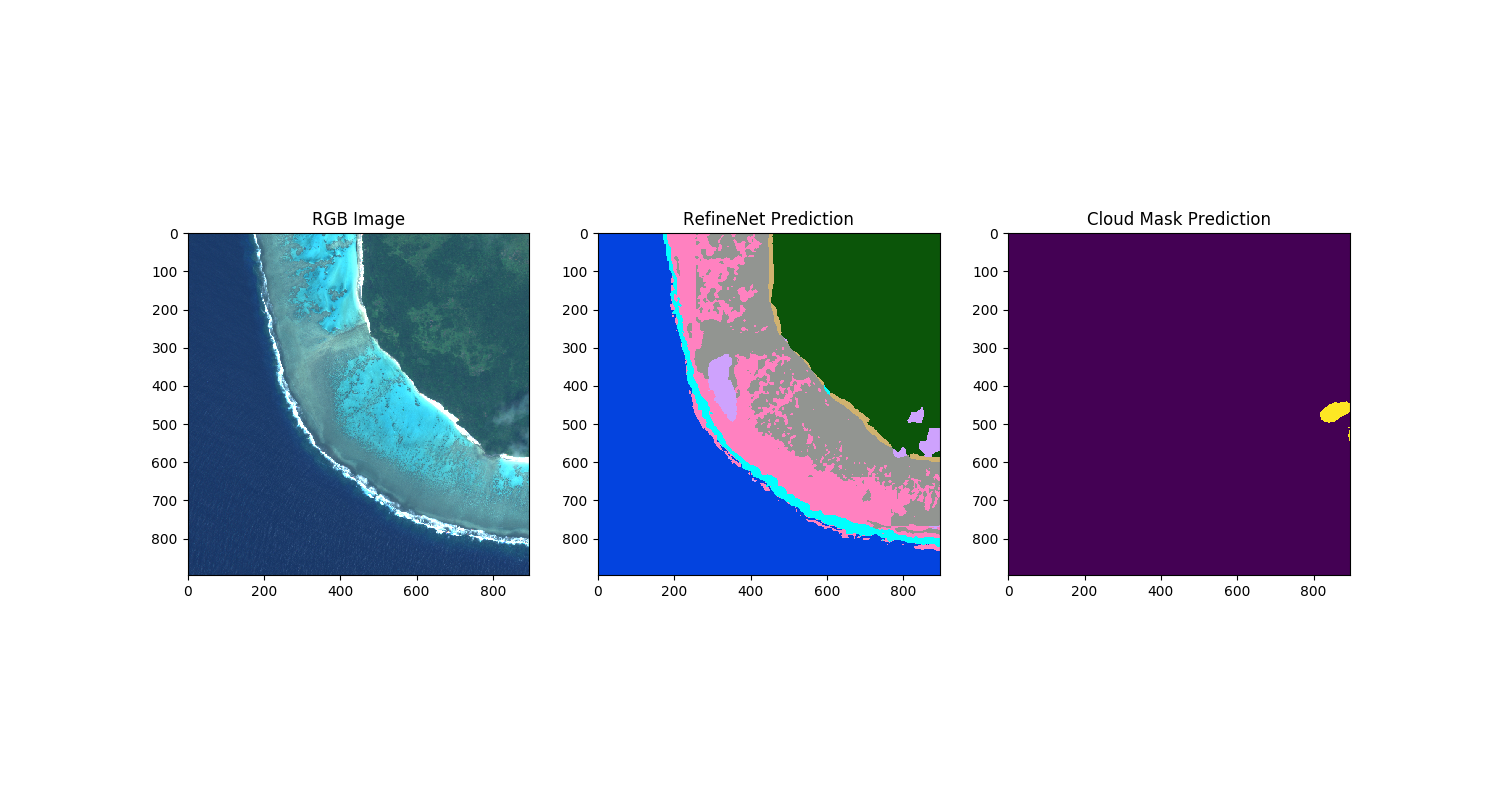

In [9]:
# PREDICTION
Fiji.set_mean_std(100,100) # set mean and standard deviation
cloud_predict, cloudnum_predict, cloudprob_predict, cloudtruth_predict, cloudaccuracy = \
    Fiji.predict_on_whole_image(cloudmodel, image_size = patch_size, num_classes = 3, spacing = (128,128), predict_size = predict_size, num_lines=None, lastchannelremove=False) # Cloud predict
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = patch_size, num_classes = len(class_indices_rev), spacing = (128,128), predict_size = predict_size, num_lines=None, lastchannelremove=False) # Predict on NeMO classes
 
# land mask
landcover = np.where(Testtruth.astype(int) == labelkey['Terrestrial vegetation']) # LOF Land Mask
for i in range(len(landcover[0])):
    temp_predict = whole_predict[landcover[0][i],landcover[1][i]].astype(int)+1
    if temp_predict != labelkey['Terrestrial vegetation'] and temp_predict != labelkey['Other or Unknown'] and temp_predict != labelkey['Clouds']:
        whole_predict[landcover[0][i],landcover[1][i]] = labelkey['Terrestrial vegetation']-1
        prob_predict[landcover[0][i],landcover[1][i],:] = 0
        prob_predict[landcover[0][i],landcover[1][i],4] = 1
        
cloudcover = np.where(np.logical_and(np.equal(whole_predict.astype(int)+1,labelkey["Clouds"]), np.not_equal(cloud_predict.astype(int),1))) # Predicted as clouds in nemo-model, but not predicted as clouds using cloud model
shadowcover = np.where(cloud_predict.astype(int) == 2)
for i in range(len(shadowcover[0])):
    cloud_predict[shadowcover[0][i],shadowcover[1][i]] = 0

fig = plt.figure(4,figsize=(15,8))
ax = plt.subplot(131)
ax.title.set_text('RGB Image')
plt.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])

ax = plt.subplot(132)
ax.title.set_text('RefineNet Prediction')
ax.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

ax = plt.subplot(133)
ax.title.set_text('Cloud Mask Prediction')
ax.imshow(cloud_predict.astype(int)+1)
plt.show()


KL-divergence at 0: -6663786.6006625015
KL-divergence at 1: -7481849.478444656
KL-divergence at 2: -7591904.088820339
KL-divergence at 3: -7616657.035483878
KL-divergence at 4: -7624949.457263845
KL-divergence at 5: -7628931.275077748
KL-divergence at 6: -7631524.910020586
KL-divergence at 7: -7633502.025730479
KL-divergence at 8: -7635164.380156175
KL-divergence at 9: -7636665.136920318
KL-divergence at 10: -7637994.42421518
KL-divergence at 11: -7639096.319401134
KL-divergence at 12: -7640069.694307787
KL-divergence at 13: -7640940.5127243325
KL-divergence at 14: -7641733.383109931
KL-divergence at 15: -7642442.731958756
KL-divergence at 16: -7643068.96085518
KL-divergence at 17: -7643652.204438166
KL-divergence at 18: -7644163.3050971655
KL-divergence at 19: -7644572.034176545


<IPython.core.display.Javascript object>


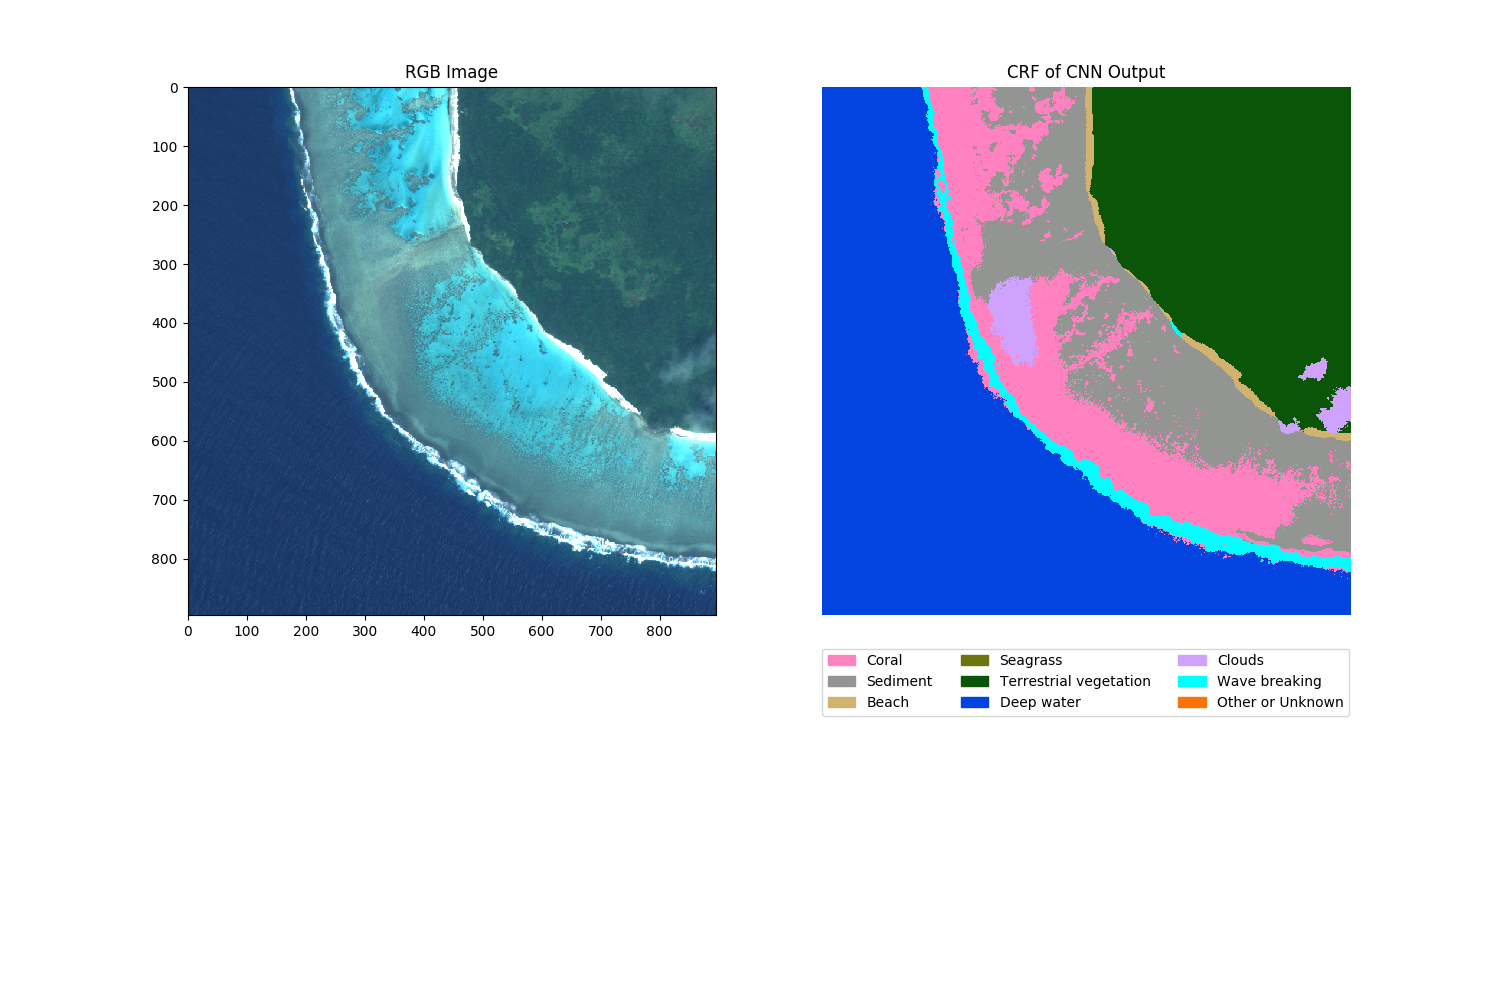

In [10]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(prob_predict,2,0)
U = unary_from_softmax(prob_predict_switch)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(5,5), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=0, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(10,10), schan=3, img=Fiji.testimage[offstart:ylen-offstart,offstart:xlen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))


fig = plt.figure(6,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
ax.title.set_text('RGB Image')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
ax.title.set_text('CRF of CNN Output')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()


# of high prob sediment:  53631
# of high prob corals:  38957
# of high prob seagrass:  0
# of high prob clouds:  3588
# of high prob ocean:  299261


<IPython.core.display.Javascript object>


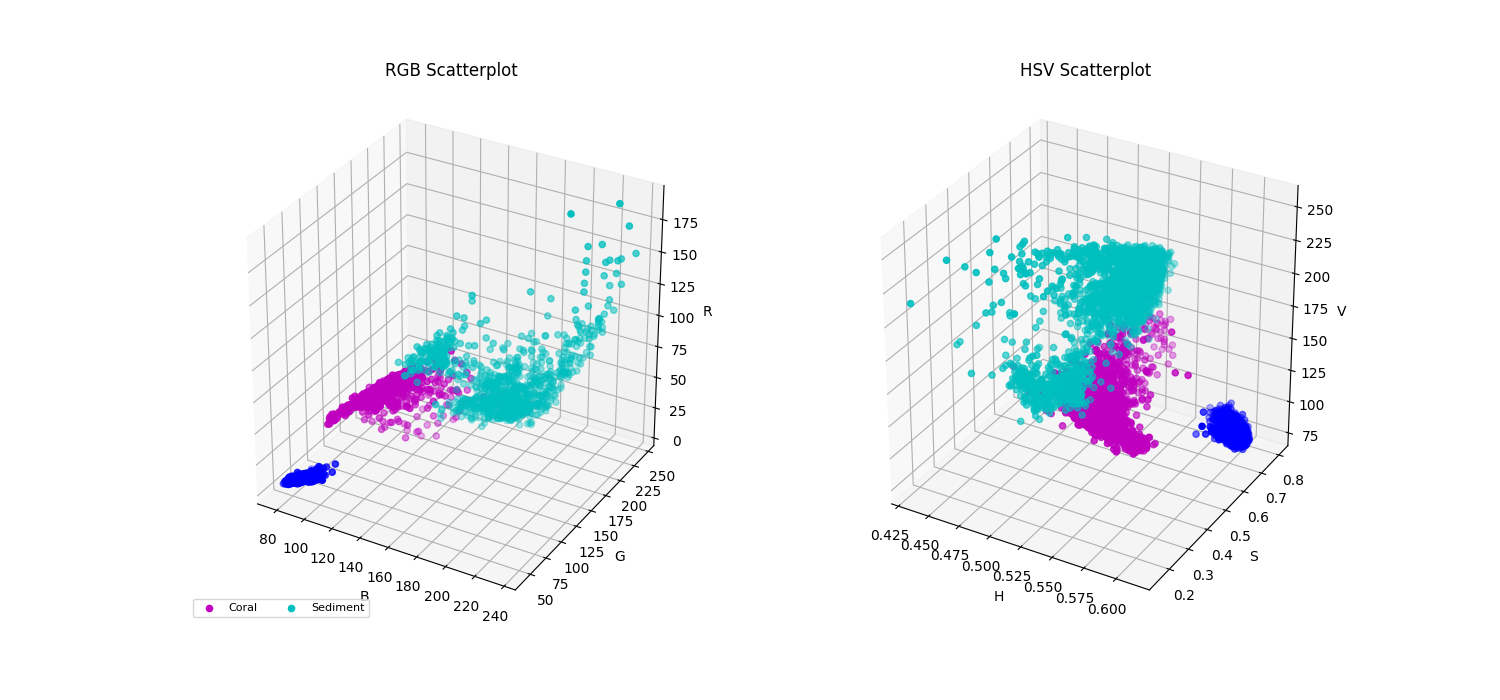

[-1  0  1  2]


<IPython.core.display.Javascript object>


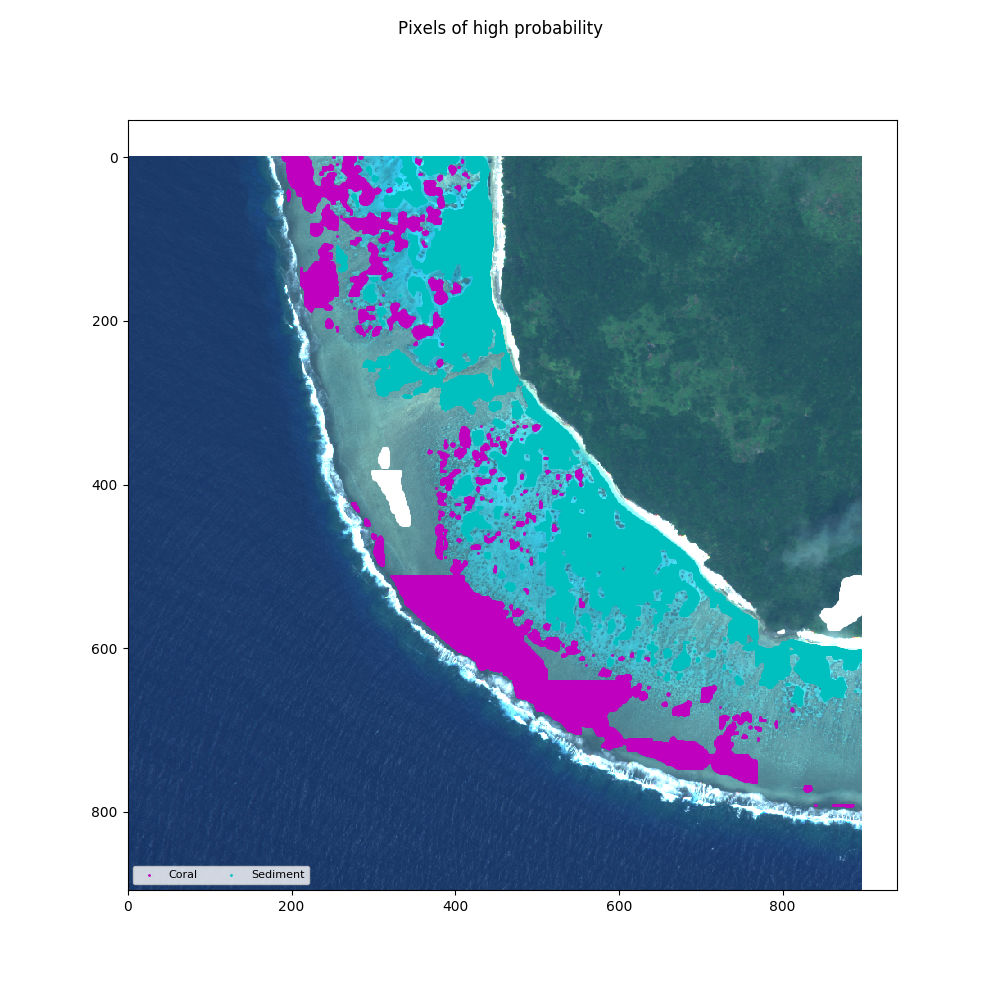

Coral statistics:  [119.96529068 109.69992132  63.62124567  19.28788405] [10.7367844  11.69779973  7.77783363  5.74751719]
Sediment statistics:  [180.21424324 166.68130516  66.06390175  15.29086608] [21.95470163 20.72010663 21.00124117  8.5177226 ]


<IPython.core.display.Javascript object>


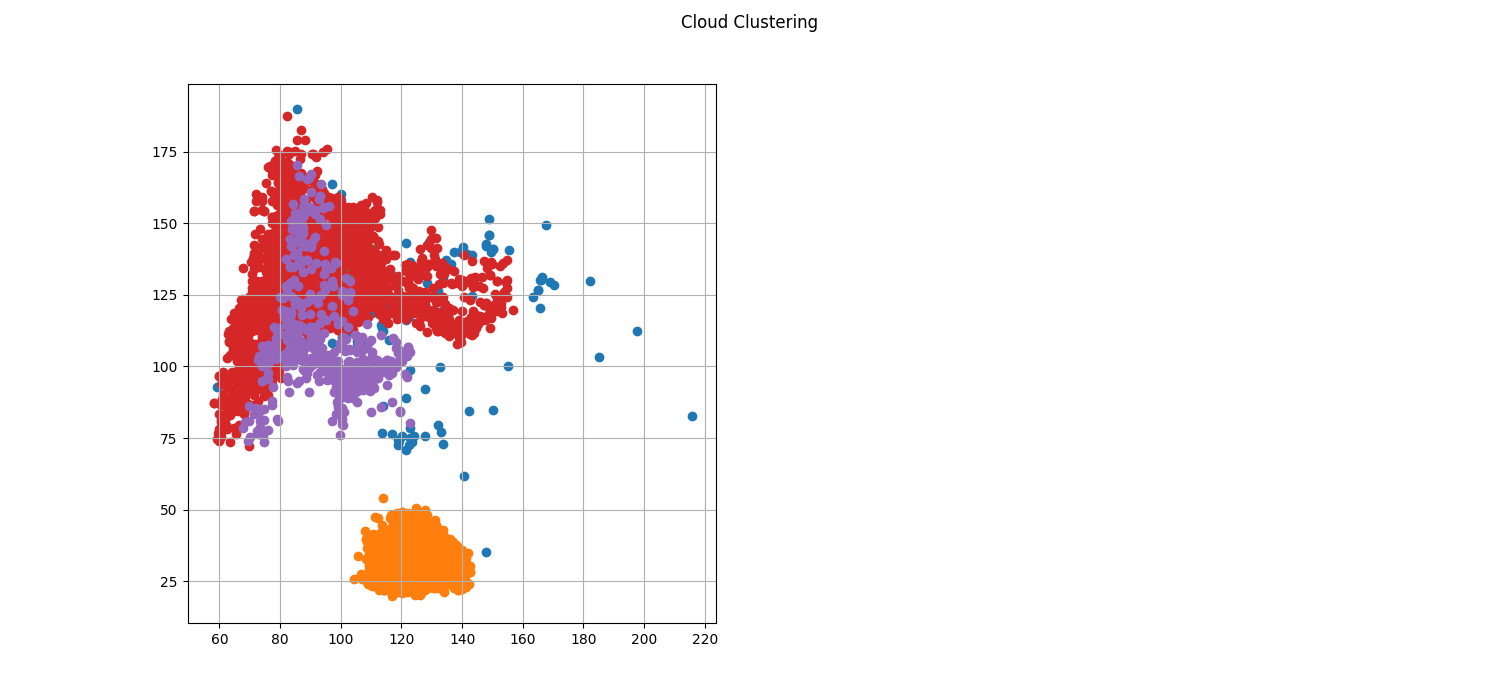

Cloud cluster  -1 :  [125.25418742 120.02007982  85.08658405 116.46679575] [24.02040623 27.83074341 27.13380571 26.32131708]
Cloud cluster  0 :  [126.66075258 122.8490036   80.91062219  29.75308029] [4.37752456 6.77715214 5.7137396  4.83153365]
Cloud cluster  0  is in sediment cluster
Cloud cluster  0  is in coral cluster
Cloud cluster  1 :  [111.69953408 103.49940922  61.29234153 141.06205676] [3.78758958 3.39222631 3.05739113 5.1704796 ]
Cloud cluster  2 :  [103.18227954  92.23821789  53.87654221 128.53306337] [16.33887125 18.90247327 15.17173583 17.85374374]
Cloud cluster  3 :  [104.35485802  94.42503528  59.41854382 109.3732588 ] [14.23718102 12.82199226 14.88724193 19.60226077]


In [15]:
# Post-Processing

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from skimage.color import rgb2hsv
from sklearn.cluster import KMeans, DBSCAN
from sklearn import svm
from sklearn import neighbors

n=3000 # number of points to take per class for the KNN
n_sg_cutoff = 300 # Number of points of cutoff for seagrass 
Fiji_HSV = rgb2hsv(Fiji.testimage[offstart:ylen-offstart,offstart:xlen-offstart,2::-1]) # Convert to HSV (isn't really used)

sediment = np.where(final_predict.astype(int)+1 == labelkey['Sediment'])
sediment_highprob = np.where(prob_predict[:,:,1] >= 0.9) # Find high probability sediment areas where probability > 0.9
print("# of high prob sediment: ", len(sediment_highprob[0]))
randomsed = np.random.randint(len(sediment_highprob[0]), size=n)
randomsed_hsv = Fiji_HSV[sediment_highprob[0][randomsed],sediment_highprob[1][randomsed],:]
randomsed = Fiji.testimage[offstart+sediment_highprob[0][randomsed],offstart+sediment_highprob[1][randomsed],:] # generate random set of sediment classes

coralprob_cutoff = 0.9 # cutoff probability for # of coral classes
corals = np.where(final_predict.astype(int)+1 == labelkey['Coral'])
corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)

# Generate # of coral classes somewhere between 0.7 to 0.75 that of number of sediment classes
while len(corals_highprob[0]) >= 0.75*len(sediment_highprob[0]) and coralprob_cutoff <= 0.95: # if too much coral classes, increase cutoff to decrease number of coral
    coralprob_cutoff = coralprob_cutoff + 0.01
    corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
while len(corals_highprob[0]) <= 0.7*len(sediment_highprob[0]) and coralprob_cutoff >= 0.5: # if too little coral classes, decrease cutoff to increase number of coral
    coralprob_cutoff = coralprob_cutoff - 0.01
    corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
print("# of high prob corals: ", len(corals_highprob[0]))
randomcorals = np.random.randint(len(corals_highprob[0]), size=n)
randomcorals_hsv = Fiji_HSV[corals_highprob[0][randomcorals],corals_highprob[1][randomcorals],:]
randomcorals = Fiji.testimage[offstart+corals_highprob[0][randomcorals],offstart+corals_highprob[1][randomcorals],:]

# Find seagrass classes where probability > 0.75
seagrass = np.where(final_predict.astype(int)+1 == labelkey['Seagrass'])
seagrass_highprob = np.where(prob_predict[:,:,3] >= 0.75)
print("# of high prob seagrass: ", len(seagrass_highprob[0]))
if len(seagrass_highprob[0]) >= n_sg_cutoff: # If there is enough seagrass, then it becomes a valid class to KNN over
    randomsg = np.random.randint(len(seagrass_highprob[0]), size=n)
    randomsg_hsv = Fiji_HSV[seagrass_highprob[0][randomsg],seagrass_highprob[1][randomsg],:]
    randomsg = Fiji.testimage[offstart+seagrass_highprob[0][randomsg],offstart+seagrass_highprob[1][randomsg],:]

# Find Clouds
clouds = np.where(np.logical_and(np.equal(final_predict.astype(int)+1,labelkey["Clouds"]), np.not_equal(cloud_predict.astype(int),1))) # Predicted as clouds in nemo-model, but not predicted as clouds using cloud model
clouds_highprob = np.where(prob_predict[:,:,6] >= 0.85)
print("# of high prob clouds: ", len(clouds_highprob[0]))
if len(clouds_highprob[0]) >= 100: # If there is enough clouds, then it becomes a valid class to KNN over
    randomclouds = np.random.randint(len(clouds_highprob[0]), size=n)
    randomclouds = Fiji.testimage[offstart+clouds_highprob[0][randomclouds], offstart+clouds_highprob[1][randomclouds],:]

# Find Ocean
ocean = np.where(final_predict.astype(int)+1 == labelkey['Deep water'])
ocean_highprob = np.where(prob_predict[:,:,5] >= 0.9)
print("# of high prob ocean: ", len(ocean_highprob[0]))
if len(ocean_highprob[0]) >= 100: # If there is enough ocean, then it becomes a valid class to KNN over
    randomocean = np.random.randint(len(ocean_highprob[0]), size=n)
    randomocean_hsv = Fiji_HSV[ocean_highprob[0][randomocean], ocean_highprob[1][randomocean],:]
    randomocean = Fiji.testimage[offstart+ocean_highprob[0][randomocean], offstart+ocean_highprob[1][randomocean],:]
    
# plot 3d scatterplot
nscatter = 1000
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
ax.title.set_text('RGB Scatterplot')
coral_scatter = ax.scatter(randomcorals[:nscatter,0], randomcorals[:nscatter,1], randomcorals[:nscatter,2], c='m',marker='o')
sediment_scatter = ax.scatter(randomsed[:nscatter,0], randomsed[:nscatter,1], randomsed[:nscatter,2], c='c',marker='o')
ocean_scatter = ax.scatter(randomocean[:nscatter,0], randomocean[:nscatter,1], randomocean[:nscatter,3], c='b', marker='o')
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    seagrass_scatter = ax.scatter(randomsg[:nscatter,0], randomsg[:nscatter,1], randomsg[:nscatter,2], c='g',marker='o')
    plt.legend((coral_scatter, sediment_scatter, seagrass_scatter), ('Coral', 'Sediment', 'Seagrass'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
else:
    plt.legend((coral_scatter, sediment_scatter), ('Coral', 'Sediment'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)

ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('R')

ax = fig.add_subplot(122, projection='3d')
ax.title.set_text('HSV Scatterplot')
ax.scatter(randomcorals_hsv[:,0], randomcorals_hsv[:,1], randomcorals_hsv[:,2], c='m',marker='o')
ax.scatter(randomsed_hsv[:,0], randomsed_hsv[:,1], randomsed_hsv[:,2], c='c',marker='o')
ax.scatter(randomocean_hsv[:,0], randomocean_hsv[:,1], randomocean_hsv[:,2], c='b', marker='o')
if len(seagrass_highprob[0]) >= 100:
    ax.scatter(randomsg_hsv[:,0], randomsg_hsv[:,1], randomsg_hsv[:,2], c='g',marker='o')
ax.set_xlabel('H')
ax.set_ylabel('S')
ax.set_zlabel('V')
plt.show()

# KNN classification algorithm between coral, sediment, (seagrass), (ocean)
combineALL = np.concatenate((randomcorals[:,:], randomsed[:,:]), axis=0)
y = np.concatenate((np.zeros(n,), np.ones(n,)), axis=0)
numcombine = 2
combineidx = {"Coral":0, "Sediment":1}
if len(seagrass_highprob[0]) >= n_sg_cutoff: # add seagrass class if enough exists
    combineALL = np.concatenate((combineALL[:,:],randomsg[:,:]), axis=0)
    y = np.concatenate((y, numcombine*np.ones(n,)), axis=0)
    combineidx["Seagrass"] = numcombine
    numcombine = numcombine+1
if len(ocean_highprob[0]) >= 100: # Add ocean class if enough exists
    combineALL = np.concatenate((combineALL[:,:],randomocean[:,:]), axis=0)
    y = np.concatenate((y, numcombine*np.ones(n,)), axis=0)
    combineidx["Ocean"] = numcombine
    numcombine = numcombine+1
clf_all = neighbors.KNeighborsClassifier(10,weights='distance')
clf_all.fit(combineALL,y)

# If there is enough clouds, start clustering all classes and find uniquelabels
if len(clouds_highprob[0]) >= 100:
    clustering = DBSCAN(eps=5, min_samples=20).fit(Fiji.testimage[offstart+clouds_highprob[0], offstart+clouds_highprob[1],:])
    uniquelabels = np.unique(clustering.labels_)
    print(uniquelabels)

fig = plt.figure(figsize=(10,10))
plt.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
coral_scatter = plt.scatter(y=corals_highprob[0], x=corals_highprob[1], c='m', s=1)
sediment_scatter = plt.scatter(y=sediment_highprob[0], x=sediment_highprob[1], c='c', s=1)
# ocean_scatter = plt.scatter(y=ocean_highprob[0], x=ocean_highprob[1], c='b', s=1)
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    seagrass_scatter = plt.scatter(y=seagrass_highprob[0], x=seagrass_highprob[1], c='g', s=3)
    plt.legend((coral_scatter, sediment_scatter, seagrass_scatter), ('Coral', 'Sediment', 'Seagrass'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
else:
    plt.legend((coral_scatter, sediment_scatter), ('Coral', 'Sediment'), scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
if len(clouds_highprob[0] >= 100):
    plt.scatter(y=clouds_highprob[0], x=clouds_highprob[1], c='w', s=1)
plt.suptitle('Pixels of high probability')
plt.show()

coral_mean = np.mean(Fiji.testimage[offstart+corals_highprob[0], offstart+corals_highprob[1],:], 0)
coral_std = np.std(Fiji.testimage[offstart+corals_highprob[0], offstart+corals_highprob[1],:], 0)
sediment_mean = np.mean(Fiji.testimage[offstart+sediment_highprob[0], offstart+sediment_highprob[1],:], 0)
sediment_std = np.std(Fiji.testimage[offstart+sediment_highprob[0], offstart+sediment_highprob[1],:], 0)
print("Coral statistics: ", coral_mean, coral_std)
print("Sediment statistics: ", sediment_mean, sediment_std)

# Cloud Fix (sometimes pixels are erroneously classified as clouds, this fixes that using clustering)
# We predict where each cloud cluster if it's in the vicinity of any sediment or coral cluster, so we know to reclassify that cluster
if len(clouds_highprob[0]) >= 100:
    cloudsX = []
    cloudsY = []
    clustermeans = []
    
    # DBSCAN to identify clusters of cloud-predicted pixels
    coordinates = 2*np.stack((offstart+clouds[0], offstart+clouds[1]), axis=-1)
    spec_and_coord = np.concatenate((Fiji.testimage[offstart+clouds[0], offstart+clouds[1],:], coordinates), axis=-1)
    
    clustering_all = DBSCAN(eps=15, min_samples=20).fit(spec_and_coord)
    uniquelabels_all = np.unique(clustering_all.labels_)
    
    # Plot clusters of cloud predicted pixels using DBSCAN
    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Cloud Clustering')
    ax = fig.add_subplot(121)
    cloud_repredict_list = []
    for l in uniquelabels_all:
        tempclass = np.where(clustering_all.labels_ == l)
        ax.scatter(Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass],1], Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass],3])
        cloudcluster_mean = np.mean(Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass]],0)
        cloudcluster_std = np.std(Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass]],0)
        print("Cloud cluster ", l, ": ", cloudcluster_mean, cloudcluster_std)
        if all((cloudcluster_mean >= sediment_mean-2.5*sediment_std) & (cloudcluster_mean <=sediment_mean+2.5*sediment_std)) and l >= 0 :
            print("Cloud cluster ", l, " is in sediment cluster")
            cloud_repredict_list.append(l)
        if all((cloudcluster_mean >= coral_mean-2.5*coral_std) & (cloudcluster_mean <=coral_mean+2.5*coral_std)) and l >= 0:
            print("Cloud cluster ", l, " is in coral cluster")
            cloud_repredict_list.append(l)
    plt.grid()
    plt.show()

<IPython.core.display.Javascript object>


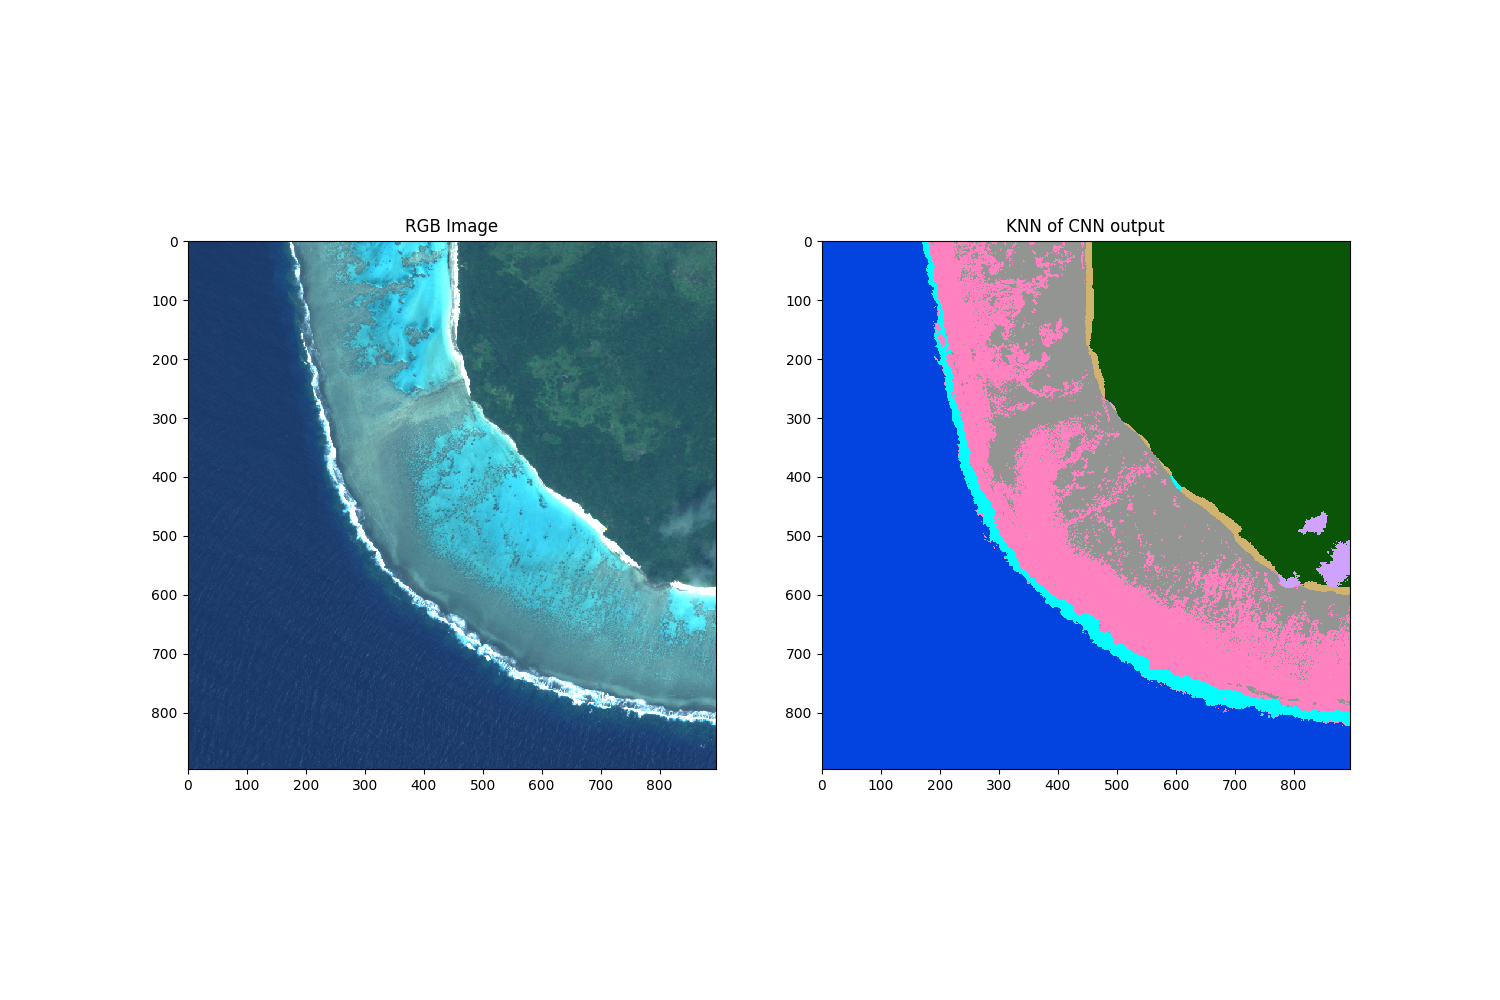

In [17]:
# Reclassification based on KNN (post-processing)

coralidx = 0
sedimentidx = 1
seagrassidx = 3
oceanidx = 5
knn_predict = np.copy(final_predict)
knn_predict_prob = np.copy(prob_predict)

# reclassify all corals
totalcorals = Fiji.testimage[offstart+corals[0][:], offstart+corals[1][:], :]
totalcorals_predict = clf_all.predict(totalcorals)
totalcorals_predictprob = clf_all.predict_proba(totalcorals)

# reclassify all sediment
totalsediment = Fiji.testimage[offstart+sediment[0][:],offstart+sediment[1][:], :]
totalsediment_predict = clf_all.predict(totalsediment)
totalsediment_predictprob = clf_all.predict_proba(totalsediment)

# If enough seagrass, reclassify all seagrass
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    totalseagrass = Fiji.testimage[offstart+seagrass[0][:], offstart+seagrass[1][:], :]
    totalseagrass_predict = clf_all.predict(totalseagrass)
    totalseagrass_predictprob = clf_all.predict_proba(totalseagrass)

# If enough clouds, reclassify only those clusters that are close to coral or sediment clusters
if len(clouds_highprob[0]) >= 100:
    totalclouds = Fiji.testimage[offstart+clouds[0][:], offstart+clouds[1][:],:]
    for i in range(len(clouds[0])):
        if clustering_all.labels_[i] in cloud_repredict_list:
            repredict_clouds = clf_all.predict(np.expand_dims(totalclouds[i], axis=0))
            repredictprob_clouds = clf_all.predict_proba(np.expand_dims(totalclouds[i], axis=0))
            if repredict_clouds[0] == combineidx["Coral"]:
                knn_predict[clouds[0][i],clouds[1][i]] = coralidx
            elif repredict_clouds[0] == combineidx["Sediment"]:
                knn_predict[clouds[0][i],clouds[1][i]] = sedimentidx
            if len(seagrass_highprob[0]) >= 100:
                if repredict_clouds[0] == combineidx["Seagrass"]:
                    knn_predict[clouds[0][i],clouds[1][i]] = seagrassidx
                knn_predict_prob[clouds[0][i],clouds[1][i],seagrassidx] = repredictprob_clouds[0][combineidx["Seagrass"]]
            knn_predict_prob[clouds[0][i],clouds[1][i],:] = 0
            knn_predict_prob[clouds[0][i],clouds[1][i],coralidx] = repredictprob_clouds[0][combineidx["Coral"]]
            knn_predict_prob[clouds[0][i],clouds[1][i],sedimentidx] = repredictprob_clouds[0][combineidx["Sediment"]]
            knn_predict_prob[clouds[0][i],clouds[1][i],oceanidx] = repredictprob_clouds[0][combineidx["Ocean"]]

# Reclassify all corals
for i in range(len(corals[0])):
    knn_predict_prob[corals[0][i],corals[1][i],:] = 0
    if totalcorals_predict[i] == combineidx["Coral"]:
        knn_predict[corals[0][i],corals[1][i]] = coralidx
    elif totalcorals_predict[i] == combineidx["Sediment"]:
        knn_predict[corals[0][i],corals[1][i]] = sedimentidx
    elif totalcorals_predict[i] == combineidx["Ocean"]:
        knn_predict[corals[0][i],corals[1][i]] = oceanidx
    if len(seagrass_highprob[0]) >= n_sg_cutoff:
        if totalcorals_predict[i] == combineidx["Seagrass"]:
            svm_predict[corals[0][i],corals[1][i]] = seagrassidx
        knn_predict_prob[corals[0][i],corals[1][i],seagrassidx] = totalcorals_predictprob[i][combineidx["Seagrass"]]

    knn_predict_prob[corals[0][i],corals[1][i],coralidx] = totalcorals_predictprob[i][combineidx["Coral"]]
    knn_predict_prob[corals[0][i],corals[1][i],sedimentidx] = totalcorals_predictprob[i][combineidx["Sediment"]]
    knn_predict_prob[corals[0][i],corals[1][i],oceanidx] = totalcorals_predictprob[i][combineidx["Ocean"]]

# Reclassify all sediment 
for i in range(len(sediment[0])):
    knn_predict_prob[sediment[0][i],sediment[1][i],:] = 0
    if totalsediment_predict[i] == combineidx["Coral"]:
        knn_predict[sediment[0][i],sediment[1][i]] = coralidx
    elif totalsediment_predict[i] == combineidx["Sediment"]:
        knn_predict[sediment[0][i],sediment[1][i]] = sedimentidx
    if len(seagrass_highprob[0]) >= n_sg_cutoff:
        if totalsediment_predict[i] == combineidx["Seagrass"]:
            svm_predict[sediment[0][i],sediment[1][i]] = seagrassidx
        knn_predict_prob[sediment[0][i],sediment[1][i],seagrassidx] = totalsediment_predictprob[i][combineidx["Seagrass"]]
        
    knn_predict_prob[sediment[0][i],sediment[1][i],coralidx] = totalsediment_predictprob[i][combineidx["Coral"]]
    knn_predict_prob[sediment[0][i],sediment[1][i],sedimentidx] = totalsediment_predictprob[i][combineidx["Sediment"]]
    knn_predict_prob[sediment[0][i],sediment[1][i],oceanidx] = totalsediment_predictprob[i][combineidx["Ocean"]]

# Reclassify all seagrass
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    for i in range(len(seagrass[0])):
        if totalseagrass_predict[i] == combineidx["Coral"]:
            knn_predict[seagrass[0][i],seagrass[1][i]] = coralidx
        elif totalseagrass_predict[i] == combineidx["Sediment"]:
            knn_predict[seagrass[0][i],seagrass[1][i]] = sedimentidx
        elif totalseagrass_predict[i] == combineidx["Seagrass"]:
            knn_predict[seagrass[0][i],seagrass[1][i]] = seagrassidx
        knn_predict_prob[seagrass[0][i],seagrass[1][i],:] = 0
        knn_predict_prob[seagrass[0][i],seagrass[1][i],coralidx] = totalseagrass_predictprob[i][combineidx["Coral"]]
        knn_predict_prob[seagrass[0][i],seagrass[1][i],sedimentidx] = totalseagrass_predictprob[i][combineidx["Sediment"]]
        knn_predict_prob[seagrass[0][i],seagrass[1][i],seagrassidx] = totalseagrass_predictprob[i][combineidx["Seagrass"]]
        knn_predict_prob[seagrass[0][i],seagrass[1][i],oceanidx] = totalseagrass_predictprob[i][combineidx["Ocean"]]
    
                
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
ax.title.set_text('RGB Image')

ax = plt.subplot(122)
ax.imshow(knn_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
ax.title.set_text('KNN of CNN output')
plt.show()

KL-divergence at 0: -7877607.129470253
KL-divergence at 1: -8369279.200758489
KL-divergence at 2: -8418699.13277272
KL-divergence at 3: -8425052.120409064
KL-divergence at 4: -8427527.074011613
KL-divergence at 5: -8428990.500837343
KL-divergence at 6: -8429921.26871886
KL-divergence at 7: -8430654.381205734
KL-divergence at 8: -8431278.195312649
KL-divergence at 9: -8431778.180902561
KL-divergence at 10: -8432149.638693701
KL-divergence at 11: -8432415.731630022
KL-divergence at 12: -8432591.29106924
KL-divergence at 13: -8432710.647878798
KL-divergence at 14: -8432811.511951013
KL-divergence at 15: -8432899.746897545
KL-divergence at 16: -8432972.053680567
KL-divergence at 17: -8433041.52914438
KL-divergence at 18: -8433108.418768575
KL-divergence at 19: -8433174.092118986


<IPython.core.display.Javascript object>


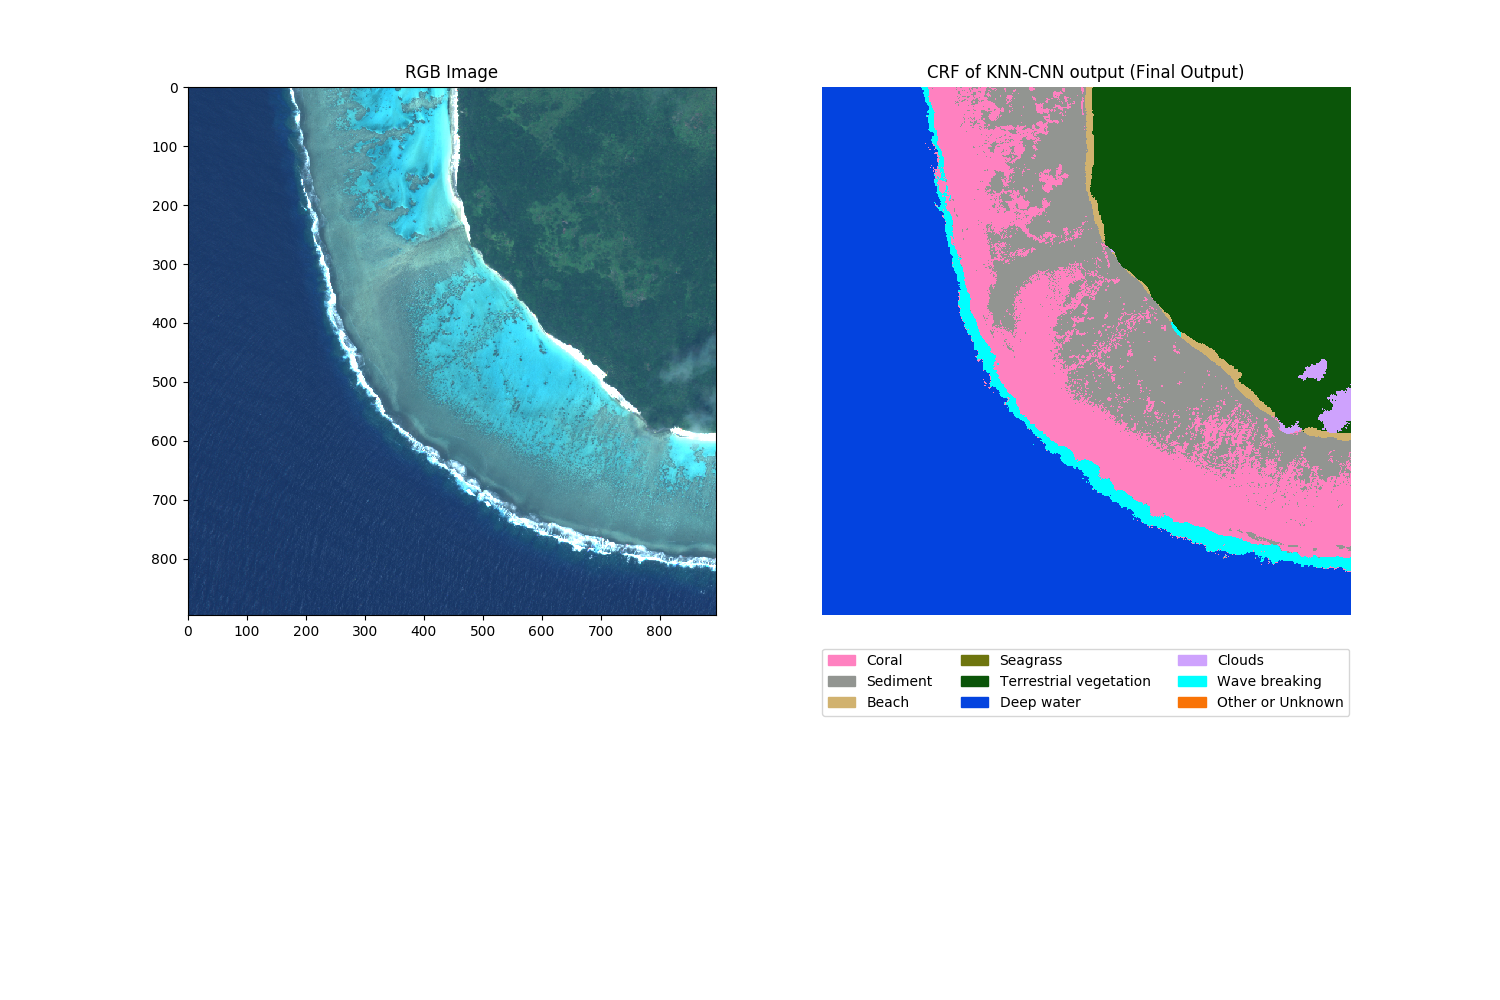

In [19]:
# CRF of KNN-CNN Post-processed results
prob_predict_switch_trans = np.rollaxis(knn_predict_prob,2,0)
U = unary_from_softmax(prob_predict_switch_trans)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(3,3), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(25,25), schan=3, img=Fiji.testimage[offstart:ylen-offstart,offstart:xlen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict_svm = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
ax.title.set_text('RGB Image')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict_svm.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
ax.title.set_text('CRF of KNN-CNN output (Final Output)')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()